# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# This project is my capstone project for Data Scientist Nanodegree in Udacity.
# In this project, I will use a machine learning model to predict whether or not someone will complete an offer based on demographics and offer portfolio.

In [1]:
import pandas as pd
import numpy as np
import math
import json
# % matplotlib inline
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Explore and understand the dataset

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
portfolio.head()
#     id (string) - offer id
#     offer_type (string) - type of offer ie BOGO, discount, informational
#     difficulty (int) - minimum required spend to complete an offer
#     reward (int) - reward given for completing an offer
#     duration (int) - time for offer to be open, in days
#     channels (list of strings)


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [5]:
profile.head()
#     age (int) - age of the customer
#     became_member_on (int) - date when customer created an app account
#     gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
#     id (str) - customer id
#     income (float) - customer's income

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [6]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [7]:
transcript.head()
#     event (str) - record description (ie transaction, offer received, offer viewed, etc.)
#     person (str) - customer id
#     time (int) - time in hours since start of test. The data begins at time t=0
#     value - (dict of strings) - either an offer id or transaction amount depending on the record

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [8]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [9]:
# male_profile = profile.loc[profile['gender'] == "M"]
# male_profile.head()
# female_profile = profile.loc[profile['gender'] == "F"]
# female_profile.head()

# 2. Data Preprocessing

# 2.1. Pivot and merge dataset

In [10]:
def get_transaction_amount(row):
    '''
    Function to extract transaction amount from column 'value' in dataset transcript
    Input: row of dataframe
    Output: transaction amount in column 'value'
    '''
    if "transaction" in row["event"]:
        return row["value"].get('amount')
    return None

In [11]:
def get_offer_id(row):
    '''
    Function to extract offer id amount from column 'value' in dataset transcript
    Input: row of dataframe
    Output: offer id in column 'value' 
            If event is 'offer completed', offer id key is stored as 'offer id'
            If event is 'offer received' or 'offer viewed', offer id key is stored as 'offer_id'
    '''
    if "offer received" in row["event"] or "offer viewed" in row["event"]:
        return row["value"].get('offer id')
    elif "offer completed" in row["event"]:
        return row["value"].get('offer_id')
    elif "transaction" in row["event"]:
        return None
    return None
    

In [12]:
# Apply above functions to transcript dataset with lambda to extract separate columns from column 'value'

transcript['trans_amount'] = transcript.apply(lambda row: get_transaction_amount(row), axis=1)

transcript['offer_id'] = transcript.apply(lambda row: get_offer_id(row), axis=1)

transcript.head(15)

,event,person,time,value,trans_amount,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,4d5c57ea9a6940dd891ad53e9dbe8da0
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},NaN,f19421c1d4aa40978ebb69ca19b0e20d
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},NaN,2298d6c36e964ae4a3e7e9706d1fb8c2
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [13]:
# Compute transaction amount per person
transaction_amount = transcript.groupby('person')['trans_amount'].sum()
transaction_amount = transaction_amount.reset_index()

transaction_amount.head()

,person,trans_amount
0,0009655768c64bdeb2e877511632db8f,127.60
1,00116118485d4dfda04fdbaba9a87b5c,4.09
2,0011e0d4e6b944f998e987f904e8c1e5,79.46
3,0020c2b971eb4e9188eac86d93036a77,196.86
4,0020ccbbb6d84e358d3414a3ff76cffd,154.05


In [14]:
# A user can receive an offer, never actually view the offer, but still spend to complete the offer 
# so an offer succeed only when the customer completes 3 steps of the offer
# To determine if a customer fully completes an offer, 
# we need to segregate event types from column 'event' into different columns
# and convert their values to numeric 0s and 1s for it to be easier to calculate

transcript['tmp'] = 1

pivot_transcript = pd.pivot_table(transcript, index=['person', 'offer_id'], columns='event', values='tmp').fillna(0)
pivot_transcript = pivot_transcript.reset_index()

pivot_transcript.head(15)

# an offer succeed only when the customer completes 3 steps of the offer
# full_completed: 1
# not_completed: 0
def get_full_completed(row):
    '''
    Function returns value 1 if customer completes 3 steps of the offer
    and 0 if 1 of 3 offer steps incomplete
    Input: row of Dataframe
    Output: 1 or 0
    '''
    if row['offer completed']==1 and row['offer received']==1 and row['offer viewed']==1:
        return 1
    return 0

pivot_transcript['full_completed'] = pivot_transcript.apply(lambda row: get_full_completed(row), axis=1)

In [15]:
pivot_transcript.head(15)

event,person,offer_id,offer completed,offer received,offer viewed,full_completed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.0,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,1.0,1.0,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,1.0,1.0,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,1.0,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0,1
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0.0,1.0,1.0,0
6,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,1.0,1.0,1
7,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1.0,1.0,1.0,1
8,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,0.0,1.0,1.0,0
9,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,0.0,1.0,1.0,0


In [16]:
# Merge to transaction_amount to include transaction amount in the dataframe.
pivot_transcript = pivot_transcript.merge(transaction_amount, how='outer', left_on='person', right_on='person')

In [17]:
# Rename columns
pivot_transcript.rename(columns = {'offer completed':'offer_completed', 'offer received':'offer_received', 'offer viewed':'offer_viewed'}, inplace = True)

In [18]:
# Merge transcript and profile based on customer id
transcript_profile = pivot_transcript.merge(profile, how='outer', left_on='person', right_on='id').drop(columns=['id'])

# Merge transcript_profile and portfolio based on offer id
transcript_profile_portfolio = transcript_profile.merge(portfolio, how='outer', left_on='offer_id', right_on='id').drop(columns=['id'])

In [19]:
transcript_profile_portfolio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63294 entries, 0 to 63293
Data columns (total 16 columns):
person              63294 non-null object
offer_id            63288 non-null object
offer_completed     63288 non-null float64
offer_received      63288 non-null float64
offer_viewed        63288 non-null float64
full_completed      63288 non-null float64
trans_amount        63294 non-null float64
age                 63294 non-null int64
became_member_on    63294 non-null int64
gender              55227 non-null object
income              55227 non-null float64
channels            63288 non-null object
difficulty          63288 non-null float64
duration            63288 non-null float64
offer_type          63288 non-null object
reward              63288 non-null float64
dtypes: float64(9), int64(2), object(5)
memory usage: 8.2+ MB


# 2.2 Dealing with null values

In [20]:
# Check null values
transcript_profile_portfolio.isnull().sum()

person                 0
offer_id               6
offer_completed        6
offer_received         6
offer_viewed           6
full_completed         6
trans_amount           0
age                    0
became_member_on       0
gender              8067
income              8067
channels               6
difficulty             6
duration               6
offer_type             6
reward                 6
dtype: int64

In [21]:
merged_df = transcript_profile_portfolio

In [22]:
# Dealing with other null values
merged_df = merged_df.dropna(how='any',axis=0)

In [23]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55222 entries, 0 to 63287
Data columns (total 16 columns):
person              55222 non-null object
offer_id            55222 non-null object
offer_completed     55222 non-null float64
offer_received      55222 non-null float64
offer_viewed        55222 non-null float64
full_completed      55222 non-null float64
trans_amount        55222 non-null float64
age                 55222 non-null int64
became_member_on    55222 non-null int64
gender              55222 non-null object
income              55222 non-null float64
channels            55222 non-null object
difficulty          55222 non-null float64
duration            55222 non-null float64
offer_type          55222 non-null object
reward              55222 non-null float64
dtypes: float64(9), int64(2), object(5)
memory usage: 7.2+ MB


In [24]:
# There's no null value now
merged_df.isnull().sum()

person              0
offer_id            0
offer_completed     0
offer_received      0
offer_viewed        0
full_completed      0
trans_amount        0
age                 0
became_member_on    0
gender              0
income              0
channels            0
difficulty          0
duration            0
offer_type          0
reward              0
dtype: int64

# 3. Exploratory Analysis and Visualization

# 3.1. Age distribution

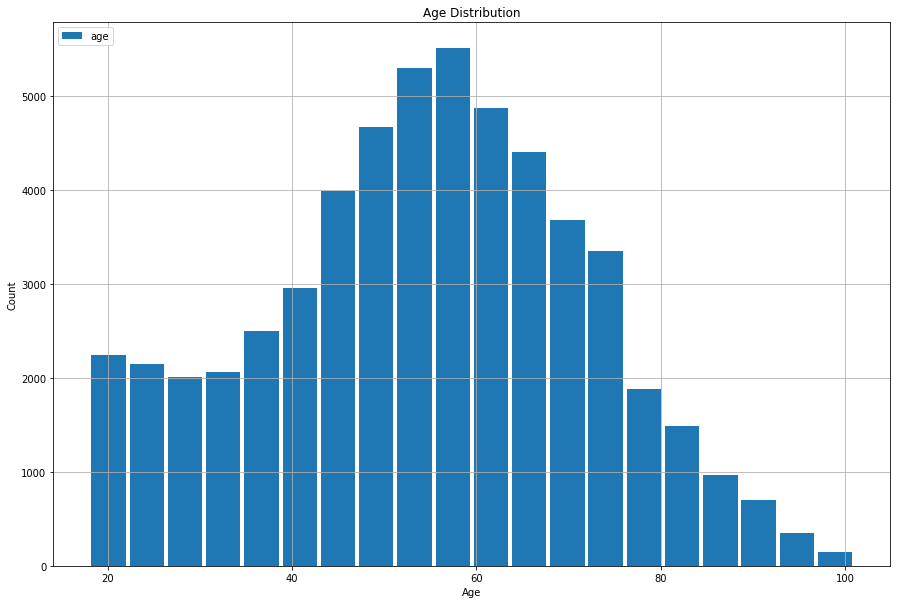

In [25]:
merged_df["age"].plot.hist(figsize=(15,10),grid=True, bins=20,rwidth=0.9, lw=3)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(loc = "upper left")
plt.show()

The graph shows us the median of age of Starbuck's customer is around 60, and most of them are between 40 and 70 years old. So Starbuck's customers seem not very young. The middle-aged people might be quite wealthy customers. We will continue to check on the income and transaction amount computed by age graphs.

# 3.2. Income by age

<Figure size 1080x720 with 0 Axes>

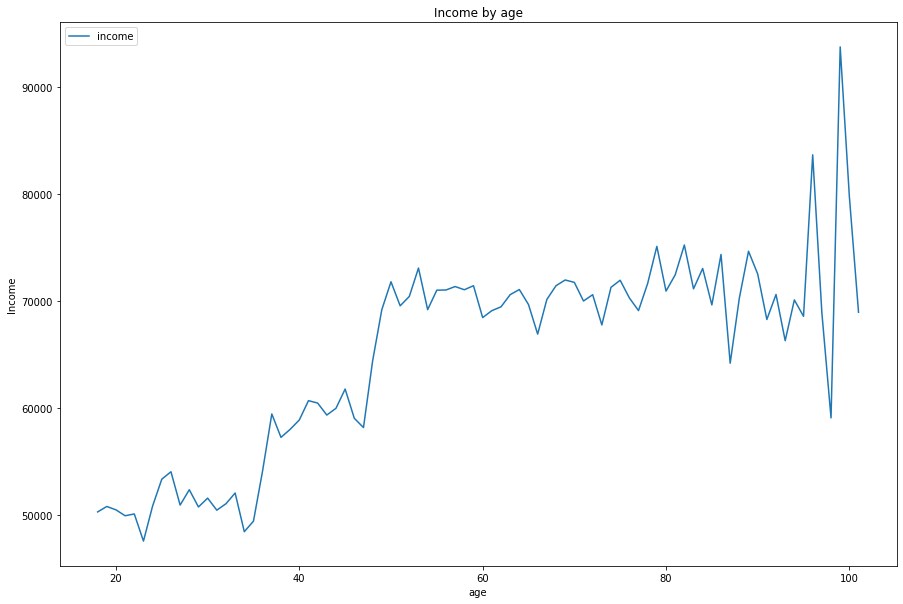

In [26]:
# Income by age
income_by_age = merged_df.groupby(['age']).agg({'income':'mean'}).reset_index()
income_by_age = income_by_age.set_index('age').sort_index()
# Visualize
fig = plt.figure(figsize =(15, 10))
lines = income_by_age.plot.line(figsize=(15,10))
plt.title('Income by age')
plt.xlabel('age')
plt.ylabel('Income')
plt.legend(loc = "upper left")
# plt.xlim(0,800)
plt.show()

Now, we can easily observe that the older customers spent more than the youngers on Starbuck's service. The average income by age has the same trend.

# 3.3. Transaction amount by age

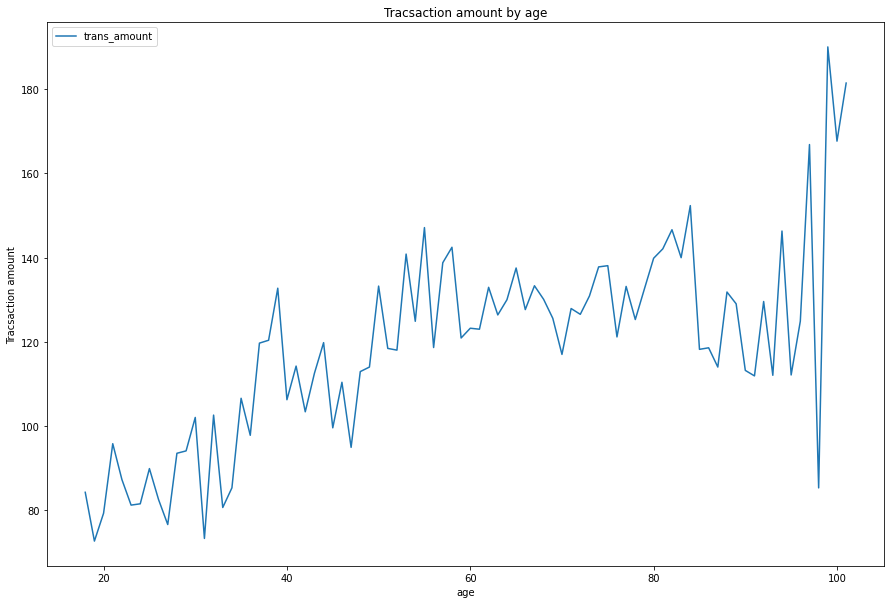

In [27]:
# Compute tracsaction amount by age
trans_by_age = merged_df.groupby(['age']).agg({'trans_amount':'mean'}).reset_index()
trans_by_age = trans_by_age.set_index('age').sort_index()
# Visualize
lines = trans_by_age.plot.line(figsize=(15,10))
plt.title('Tracsaction amount by age')
plt.xlabel('age')
plt.ylabel('Tracsaction amount')
plt.legend(loc = "upper left")
# plt.xlim(0,800)
plt.show()

# 3.4. Percentage of customers who got successful offers

Text(0.5, 1.0, 'Percentage of customers who got successful offers')

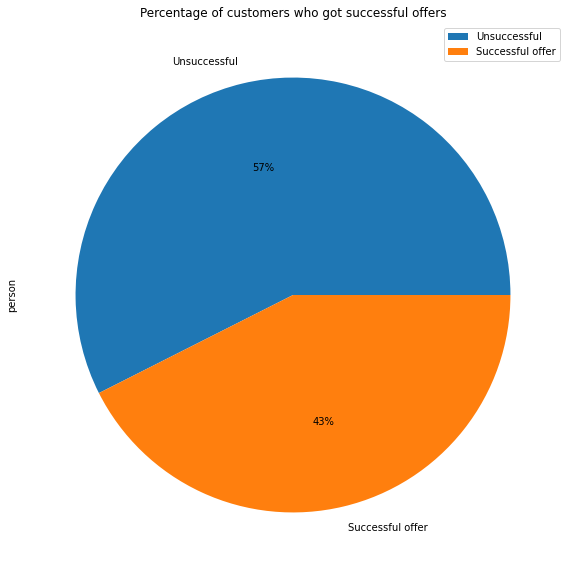

In [28]:
# Count successful offers (when a customer completes 3 steps of offer processing)
successful_offers = merged_df.groupby(['full_completed']).count()

successful_offers.plot(figsize=(10,10), kind='pie', y='person', autopct='%1.0f%%', labels = ["Unsuccessful", "Successful offer"])
plt.title('Percentage of customers who got successful offers')

There are more than a half of customers (57%) in this dataset could not complete the offer. The reasons might not only they haven't spent enough to complete it, but it could be they have never seen the offer they received.

# 4. Predictive Modeling

In [29]:
# We remove the columns that have the same meaning as index value
features = merged_df.drop(columns=['offer_id', 'person', 'offer_completed','offer_received', 'offer_viewed','became_member_on'])

In [30]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55222 entries, 0 to 63287
Data columns (total 10 columns):
full_completed    55222 non-null float64
trans_amount      55222 non-null float64
age               55222 non-null int64
gender            55222 non-null object
income            55222 non-null float64
channels          55222 non-null object
difficulty        55222 non-null float64
duration          55222 non-null float64
offer_type        55222 non-null object
reward            55222 non-null float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.6+ MB


In [31]:
# Convert all values to integer
features['channels_str'] = [','.join(map(str, l)) for l in features['channels']]
channels = features["channels_str"].unique()
channels = {channels[i] : i for i in range(len(channels))}

# Genders
genders = features["gender"].unique()
genders = {genders[i] : i for i in range(len(genders))}

# Offer types
offer_types = features["offer_type"].unique()
offer_types = {offer_types[i] : i for i in range(len(offer_types))}

x = features.drop(columns=['full_completed', 'channels'])
y = features['full_completed']

x['gender'] = x['gender'].replace(genders)
x['channels_str'] = x['channels_str'].replace(channels)
x['offer_type'] = x['offer_type'].replace(offer_types)

x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55222 entries, 0 to 63287
Data columns (total 9 columns):
trans_amount    55222 non-null float64
age             55222 non-null int64
gender          55222 non-null int64
income          55222 non-null float64
difficulty      55222 non-null float64
duration        55222 non-null float64
offer_type      55222 non-null int64
reward          55222 non-null float64
channels_str    55222 non-null int64
dtypes: float64(5), int64(4)
memory usage: 4.2 MB


In [32]:
feature_names = x.columns
labels = y.unique

In [33]:
#split into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# 4.1. Decision Tree Classifier

In [34]:
# Build Decision Tree Classifier model
list_score = []
n = 13
for i in range(1,n):
    dtree = DecisionTreeClassifier(max_depth=i, random_state=5)
    dtree.fit(x_train,y_train)
    y_pred = dtree.predict(x_test)
    list_score.append(round(accuracy_score(y_test,y_pred),4))
print(f"Max_depth: {list_score.index(max(list_score))}")
print(f"Max Accuracy Score: {max(list_score)}")

Max_depth: 7
Max Accuracy Score: 0.8245


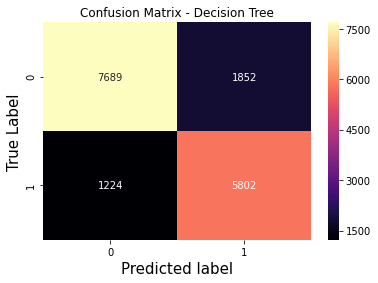

<Figure size 720x720 with 0 Axes>

In [35]:
# Compute confusion matrix and visualize
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
matrix_df = pd.DataFrame(confusion_matrix)
ax = plt.axes()
plt.figure(figsize=(10,10))
sns.heatmap(matrix_df, annot= True, fmt="g", ax=ax, cmap="magma")
ax.set_title('Confusion Matrix - Decision Tree')
ax.set_xlabel("Predicted label", fontsize=15)
ax.set_ylabel("True Label", fontsize=15)
plt.show()

In [36]:
# Classification report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

        0.0       0.86      0.81      0.83      9541
        1.0       0.76      0.83      0.79      7026

avg / total       0.82      0.81      0.82     16567



# 4.2. K-nearest neighbors Classifier

In [37]:
# Build KNN Classifier model
model = KNeighborsClassifier(n_neighbors=50)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
# accuracy score of the model
accuracy_score = model.score(x_test, y_test)

print(f"Accuracy score: {accuracy_score}")

Accuracy score: 0.6912536971087101


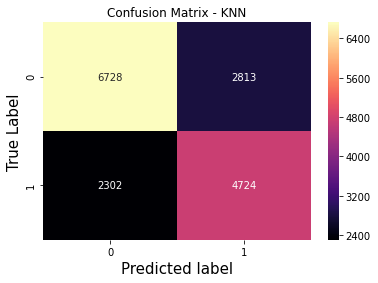

<Figure size 720x720 with 0 Axes>

In [38]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
matrix_df = pd.DataFrame(confusion_matrix)
ax = plt.axes()
plt.figure(figsize=(10,10))
sns.heatmap(matrix_df, annot= True, fmt="g", ax=ax, cmap="magma")
ax.set_title('Confusion Matrix - KNN')
ax.set_xlabel("Predicted label", fontsize=15)
ax.set_ylabel("True Label", fontsize=15)
plt.show()

In [39]:
# Classification report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

        0.0       0.75      0.71      0.72      9541
        1.0       0.63      0.67      0.65      7026

avg / total       0.69      0.69      0.69     16567



As we can see, the accuracy score of this model is just about 0.69, much lower than Decision Tree. We can have a look into the confusion matrix and classification report of this model.

It is clear that the result of Decision tree is better than KNN's. We can suggest to use Decision Tree Classifier in this case.

# 5. Conclusion

I just tried to build 2 models KNN and DecisionTree to predict whether or not a customer will fully complete an offer. The accuracy score of DecisionTree is nearly 82%, better than KNN, just about 69%. However, to improve the result, I think I can try more models and there are still many ways to explore this dataset, which may give me more interesting information.

I still confused about how to choose the right model, and what makes a model generate a better results than the others on a dataset. I will continue to investigate and learn.
